<h1>Team: QemSpin <h1>
<h1>Last updated: 8th October 2023.<h1>

#  Introduction to our work

<font size=5>
1: Circuit Optimization. The conventional Givens gate encompasses both single and double excitation gates, thereby ensuring the conservation of particle numbers, that is, the Hamming weight of the quantum state remains consistent(i.e. 9 for OH). However, this comprehensiveness also escalates the simulation cost substantially. To enhance efficiency, we optimized the conventional Givens gate by eliminating the minimal contributions from both single and double excitation states. <br>

2: Error mitigation. We used VQE to calculate the energy values of the three quantum circuits, and linearly fitted the obtained energy values, extrapolating them to the energy values without noise.

## 1 Circuit Optimization.
<font size=5>

* We implement it on the SpinQit platform. As the result, we optimized the number of single excited state gates from 13 to 1, and the number of double excited state gates from 46 to 1.

* Please refer to Chosed_Adapt_Givens_Ansatz for the results.

### 1.1 The optimized circuit.
<div align=left><img src="IMG/Optimized_Circuit.png" width=800 length=800></div>

## 1.2 The results of a circuit with and without noise.

In [1]:
from datetime import datetime

import numpy as np
import time

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper,ParityMapper,QubitConverter
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.optimizers import *  


from Estimator_with_noise import estimator_noise
from Estimator_without_noise import estimator_expect
from Ansatz import Adapt_Givens_Ansatz
from Noise_models import fakecairo, fakekolkata, fakemontreal


In [2]:
# Set up molecule
ultra_simplified_ala_string = """
O 0.0 0.0 0.0
H 0.45 -0.1525 -0.8454
"""
driver = PySCFDriver(
    atom=ultra_simplified_ala_string.strip(),
    basis='sto3g',
    charge=1,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)
qmolecule = driver.run()
mapper = JordanWignerMapper()

/home/dev/anaconda3/envs/Qikist_Chemistry/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
# Set up VQE
seed_pool = [20, 21, 30, 33, 36, 42, 43, 55, 67, 170]
noise_word = ['fakecairo','fakekolkata','fakemontreal']
ansatz = Adapt_Givens_Ansatz()
optimizer = COBYLA(maxiter=100)
ground_energy = -74.38714627
shots = 6000

## 1.2.1 Computed the ground energy without noise

In [4]:
average_error_rate, average_times = 0, 0

seed = 20
    
# Callback to store intermediate results during optimization
parameters_list = []
values = []
last_call_time = None

def callback(eval_count, parameters, mean, std):
    global last_call_time
    current_call_time = datetime.now()
    if last_call_time is not None:
        print(f"Cost Time: {current_call_time - last_call_time}")

    last_call_time = current_call_time
    parameters_list.append(parameters)
    values.append(mean)
    print(f'iter: {len(parameters_list)}, loss: {mean}, params: {parameters}')        
    
estimator = estimator_expect(seed, shots)

vqe_solver = VQE(estimator, ansatz, optimizer, callback=callback)
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

start_time = time.time()
res = calc.solve(qmolecule)
end_time = time.time()

cost_time = end_time - start_time
result = res.computed_energies + res.nuclear_repulsion_energy
error_rate = abs((ground_energy - result) / ground_energy * 100)

with open(f'Documents/Data_Without_Noise/Exact_expect_Adapt_Givens_COBYLA.txt'.format(),"a") as f:
    f.write(f'seeds = {seed},Time = {cost_time}, '
                f'energy = {res.computed_energies}, Error rate: {error_rate},parameters = {parameters_list[-1]} '
                f'optimizer = COBYLA, Ansatz = Adapt_Givens \n')

/home/dev/anaconda3/envs/Qikist_Chemistry/lib/python3.11/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


iter: 1, loss: -78.68292594370693, params: [0.0, 0.0]
Cost Time: 0:00:02.426173
iter: 2, loss: -78.39810213033573, params: [1.0, 0.0]
Cost Time: 0:00:02.245257
iter: 3, loss: -74.12025163842307, params: [0.0, 1.0]
Cost Time: 0:00:02.255648
iter: 4, loss: -74.14383651084304, params: [-0.062303476699451805, -0.9980572512592456]
Cost Time: 0:00:02.236001
iter: 5, loss: -77.41450850384622, params: [-0.031151738349725903, -0.4990286256296228]
Cost Time: 0:00:02.224754
iter: 6, loss: -78.36897163863138, params: [-0.027649021895338667, 0.24846635906744213]
Cost Time: 0:00:02.217408
iter: 7, loss: -78.68093303149374, params: [-0.12423317953372108, -0.013824510947669335]
Cost Time: 0:00:02.210554
iter: 8, loss: -78.37203915926996, params: [0.030800958338024428, -0.2480953465211697]
Cost Time: 0:00:02.212631
iter: 9, loss: -78.63522587990495, params: [0.015400479169012214, -0.12404767326058486]
Cost Time: 0:00:02.210048
iter: 10, loss: -78.68434301655016, params: [-0.004314844765565277, 0.062350

## 1.2.2 Computed the ground energy with noise.

In [5]:
## Computed the ground energy with noise
for index, noise in enumerate(noise_word):
    noise_model = globals()[noise]()
    average_error_rate, average_times = 0, 0
    
    for seed in seed_pool:
        print(f'\n Seed = {seed}, Noise model = {noise}')


        # Callback to store intermediate results during optimization
        parameters_list = []
        values = []
        last_call_time = None


        def callback(eval_count, parameters, mean, std):
            global last_call_time
            current_call_time = datetime.now()
            if last_call_time is not None:
                print(f"Cost Time: {current_call_time - last_call_time}")

            last_call_time = current_call_time
            parameters_list.append(parameters)
            values.append(mean)
            print(f'iter: {len(parameters_list)}, loss: {mean}, params: {parameters}')        
            
        estimator = estimator_noise(seed, shots, noise_model)
        
        vqe_solver = VQE(estimator, ansatz, optimizer, callback=callback)
        vqe_solver.initial_point = [0.0] * ansatz.num_parameters
        
        calc = GroundStateEigensolver(mapper, vqe_solver)
        
        start_time = time.time()
        res = calc.solve(qmolecule)
        end_time = time.time()
        
        cost_time = end_time - start_time
        result = res.computed_energies + res.nuclear_repulsion_energy
        error_rate = abs((ground_energy - result) / ground_energy * 100)
        
        with open(f'Documents/Data_With_Noise/noise_{noise}_Adapt_Givens_COBYLA.txt'.format(),"a") as f:
            f.write(f'Noise_model: {noise}, seeds = {seed},Time = {cost_time}, '
                     f'energy = {res.computed_energies}, Error rate: {error_rate},parameters = {parameters_list[-1]} '
                     f'optimizer = COBYLA, Ansatz = Adapt_Givens \n')
            
        average_error_rate += error_rate
        average_times += cost_time
        
    # with open(f'Documents/noise_{noise}_Adapt_Givens_COBYLA.txt'.format(),"a") as f:
    #     f.write(f'Noise_model: {noise}, optimizer = COBYLA, Average_Time = {average_times / len(seed_pool)}, '
    #              f'Average Error rate: {average_error_rate/len(seed_pool)}\n')



 Seed = 20, Noise model = fakecairo
iter: 1, loss: -78.09897168525526, params: [0.0, 0.0]
Cost Time: 0:01:03.919138
iter: 2, loss: -77.82979770285337, params: [1.0, 0.0]
Cost Time: 0:01:03.449727
iter: 3, loss: -73.86071177102895, params: [0.0, 1.0]
Cost Time: 0:01:03.288184
iter: 4, loss: -73.87198389929995, params: [-0.06338279313416142, -0.9979892892884733]
Cost Time: 0:01:03.422777
iter: 5, loss: -76.87966211753884, params: [-0.03169139656708071, -0.49899464464423665]
Cost Time: 0:01:03.664226
iter: 6, loss: -77.84216968097915, params: [-0.027185921689837845, 0.24851745544704498]
Cost Time: 0:01:03.807601
iter: 7, loss: -78.09854594995649, params: [-0.12425872772352252, -0.013592960844918926]
Cost Time: 0:01:03.433677
iter: 8, loss: -77.8415536138425, params: [0.028009769496142378, -0.24842595036101395]
Cost Time: 0:01:03.487627
iter: 9, loss: -78.03877444549656, params: [0.014004884748071189, -0.12421297518050697]
Cost Time: 0:01:03.632448
iter: 10, loss: -78.07945628290523, para

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

## 2： Error mitigation.

### 2.1 We used VQE to calculate the energy values of the following three quantum circuits, and linearly fitted the obtained energy values, extrapolating them to the energy values without noise.
<font size=5>

* Scale one: 
<div align=left><img src="IMG/scale_one.png" width=800 length=800></div>

* Scale three: 
<div align=left><img src="IMG/scale_three.png" width=800 length=800></div>

* Scale five: 
<div align=left><img src="IMG/scale_five.png" width=800 length=800></div>

## 2.2 Data Fitting

The coefficients are: a=-78.17726818085639, b=-0.0006923870390889242
The energy with non-noise in fakecairo model: ,-78.17726818085639 



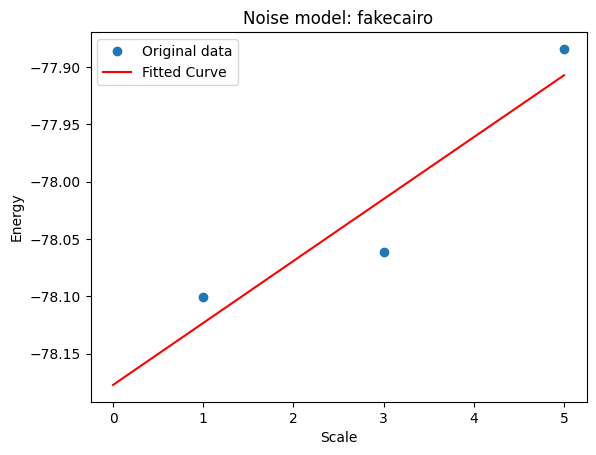

The coefficients are: a=-77.76715486840865, b=-0.0008121814922221507
The energy with non-noise in fakekolkata model: ,-77.76715486840865 



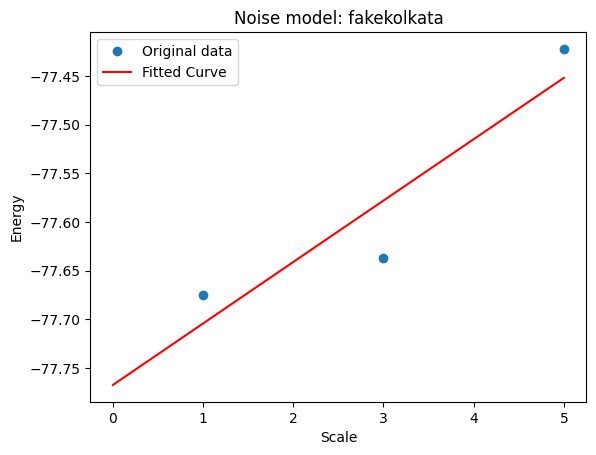

The coefficients are: a=-77.55416703848799, b=-0.0010357349660986945
The energy with non-noise in fakemontreal model: ,-77.55416703848799 



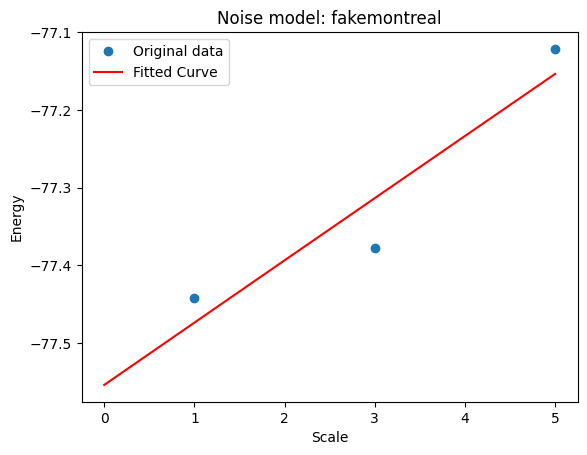

In [13]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
noise_word = ['fakecairo','fakekolkata','fakemontreal']

for noise in noise_word:
    # 原始数据点
    x = np.array([1, 3, 5])
    y = np.load(f'Documents/Error_mitigation_data/{noise}_seed_20.npy')

    # 定义指数函数模型
    def model(x, a, b ):
        return a * np.exp(b * x)

    # 进行指数拟合
    popt, pcov = curve_fit(model, x, y)
    a, b  = popt

    # 打印拟合参数
    print(f"The coefficients are: a={a}, b={b}")

    value_at_zero = model(0, a, b)
    print(f'The energy with non-noise in {noise} model: ,{value_at_zero} \n')

    # 生成用于绘制拟合函数的数据点
    x_plot = np.linspace(0, 5, 1000)
    y_plot = model(x_plot, a, b)

    # 绘制原始数据点
    plt.plot(x, y, 'o', label='Original data')

    # 绘制拟合曲线
    plt.plot(x_plot, y_plot, 'r-', label='Fitted Curve')

    plt.title(f'Noise model: {noise}')
    plt.xlabel('Scale')
    plt.ylabel('Energy')
    plt.legend()
    plt.savefig(f'IMG/Data_Fitting/{noise}_seed_20.png')
    plt.show()

# Conslusion

- Average error rate under noise-free conditions and  with noise
<div align=left><img src="IMG/Average error rate under noise-free conditions and  with noise.png" width=800 length=800></div>

- Error rate with noise and under error mitigaion while seed is 20 
<div align=left><img src="IMG/Error rate  with noise and under mitigation while seed is 20.png" width=800 length=800></div>